# DS-поток, весна 2025
## Задание ADL.3
### LLM, Alignment.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Баллы за задание:**

* Задача 1 &mdash; 40 баллов;
* Задача 2 &mdash; 60 баллов.

In [1]:
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu110/torch_nightly.html -U
!pip install -U vllm --pre --extra-index-url https://wheels.vllm.ai/nightly

In [2]:
import json

import torch
import unsloth
import numpy as np
import random
from sklearn.metrics import accuracy_score
import gc
from tqdm import tqdm

from trl import (
    SFTTrainer,
    DataCollatorForCompletionOnlyLM
)

from datasets import Dataset, load_dataset
from transformers import (
    TrainingArguments,
    AutoModelForCausalLM,
    AutoTokenizer, 
    LlamaTokenizerFast
)
from unsloth import (
    FastLanguageModel,
    is_bfloat16_supported
)
from unsloth.chat_templates import get_chat_template

from vllm import LLM, SamplingParams
from vllm.sampling_params import GuidedDecodingParams

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-04-18 17:18:49.388042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744996729.632732      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744996729.695327      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-18 17:19:12 [__init__.py:239] Automatically detected platform cuda.


---
### Задача 1. 

В этой задаче вам предложено провести сравнительное исследование, оценив эффективность нескольких LLM в различных форматах: zero-/few-shot для задачи анализа тональности текста на датасете отзывов IMDB.

---
**Форматы zero-/few-shot**

Современные большие языковые модели (LLM), обученные следовать инструкциям, позволяют решать задачи классификации, если правильно оформить запрос к ним. Подготовку надежной инструкции для решения задачи иногда еще называют промптингом. Подробнее можно почитать <a href="https://docs.mistral.ai/guides/prompting_capabilities/" target="_top">здесь</a> или <a href="https://huggingface.co/docs/transformers//tasks/prompting" target="_top">здесь</a>, или самостоятельно обсудить с LLM!


Рассмотрим два довольно популярных подхода.
* *Zero-Shot* \
  Модель выполняет задачу, опираясь только на инструкцию, без дополнительных примеров. Допустим вы можете сформулировать запрос к модели так:
  ```
  Определи, POSITIVE или NEGATIVE тон у этого текста: {текст}.
  ```
  <br>
* *Few-Shot* \
  Модель получает $k$ **примеров вместе с ответом** перед основным запросом. Это позволяет познакомить модель, например, с форматом ответа и показать какие-то паттерны через демонстрацию. \
  Рассмотрим возможный `2-shot` формат. Он предполагает демонстрацию на **двух примерах вместе с референсным ответом**. Третьим запросом будет идти целевой:

  ```
  Пример 1: "Фильм ужасен..." → NEGATIVE
  Пример 2: "Это шедевр!" → POSITIVE
  Задача: Определи тональность для "{текст}".
  ```

Обратим внимание, что Few-Shot-подход можно реализовать разными способами в зависимости от API или чат-интерфейса модели.

1. Использовать системный промпт и указать инструкцию **вместе с примерами** прямо там.

```
system_prompt = """
Ты классифицируешь тональность текста. Вот примеры:  
- "Фильм ужасен..."\nОтвет: NEGATIVE  
- "Это шедевр!"\nОтвет: POSITIVE  
Отвечай только метками POSITIVE/NEGATIVE.  
"""
```

В таком случае в `user`-реплике будет содержаться только текст целевого отзыва. При этом можно поступить иначе и использовать, например, стандартный системный промпт, рекомендованный разработчиками модели. Тогда инструкцию и few-shot примеры можно поместить сразу в `user`-реплику.


2. Используя чат-шаблон (chat-template). Тогда k-shot вариант можно реализовать следующим образом:

```
{"role": "system", "content": "Ты классифицируешь тональность текста."},  # Общая инструкция в сис. промпте, но можно и в user-реплику!
{"role": "user", "content": "Отзыв: 'Сюжет скучный...'\nОтвет:"},         # Пример 1
{"role": "assistant", "content": "NEGATIVE"},                             # Важно: ответ модели заполнен нами самостоятельно! Его можно взять из train-сета
...
{"role": "user", "content": "Отзыв: 'Лучший фильм года!'\nОтвет:"},       # Пример k
{"role": "assistant", "content": "POSITIVE"},                             # Ответ для примера k
{"role": "user", "content": "Отзыв: '{review}'\nОтвет:"}                  # Тут расположен целевой пример для прогона
```
В данном случае $k$ примеров, которые можно взять из обучающей выборки, вместе с ответами и примером для инференса принудительно помещены в историю диалога. Модель, генерируя след. реплику, выдаст нам ответ на задачу, а примеры в контексте позволят лучше следовать формату ответа и потенциально повысят итоговое качество.

Выбор стратегии, вообще говоря, зависит от пользователя и ограничений модели. Например, некоторые модели могут не поддерживать системный промпт.

---

Итак, вам требуется применить **две** open-source LLM для задачи sentiment analysis на датасете IMDB и сравнить их производительность в режимах zero- и few-shot на **валидационной подвыборке размера 2k сэмплов.**

Для few-shot используйте $k=5$ примеров, которые возьмите случайным образом из обучающей выборки. Выбор конкретного формата из описанных выше остается на вашей стороне :)


**Подумайте**, должны ли few-shot примеры быть сбалансированы, то есть содержать приблизительно одинаковое кол-во позитивных и негативных примеров? Какие стратегии выбора фьюшот примеров вы можете предложить?

В качестве LLM используйте `Qwen/Qwen2.5-3B` и `unsloth/Llama-3.2-1B-Instruct` с HuggingFace. Попробуйте **поэкспериментировать с различными вариантами промпта**. Можете взять за основу пример с семинара и воспользоваться ИИ-инструментами для его усовершенствования. Сравните результат с моделью на базе RNN, с которой вы имели дело ранее.

Представьте результат в виде аккуратной таблицы, в которой укажите модель вместе с используемым форматом (zero-/few-shot), а также итоговую точность (accuracy). Сделайте выводы.

**Должны ли примеры быть равномерно сбалансированы:**

С одной стороны равномерно сбалансированные примеры помогут модели посмотреть на все возможные случаи. 

С другой стороны, может оказаться так, что на самом деле сами данные несбалансированные - например, негативные отзывы оставляют намного реже, чем позитивные, а такой few-shot может заставить модель подумать иначе

Так как у нас всего $k=5$, а классифицируем мы отзывы с, в целом, по логике примерно равновесными классами, то лучше всего гарантировать балансировку. Возьмем 3 положительных и 2 отрицательных отзыва. Эти отзывы можно взять одинаковыми и фиксированными для всех моделей, чтобы гарантировать меньшую стохастичность результатов. 

*Замечание* \
*Для инференса рекомендуется использовать `vLLM.` Метод `.chat` может обрабатывать батч запросов, что позволит ускорить вычисления и повысить утилизацию GPU.*
```
batch_indices = range(batch_start, batch_start + batch_size)
batch_data = data.select(batch_indices)
conversations = [[{"role": "user", "content": format_text_request(review)}] for review in batch_data["review"]]
outputs = model.chat(conversations, ...)
```

In [3]:
data = load_dataset(
    "scikit-learn/imdb", split="train"
).train_test_split(test_size=0.2, seed=42)
data

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB%20Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 10000
    })
})

In [41]:
train_data = data["train"]
test_data = data["test"]

validation_subsample= test_data.select(range(1000))

Выберем примеры для few-shot

In [5]:
positive_examples = [ex for ex in train_data if ex["sentiment"] == 'positive']
negative_examples = [ex for ex in train_data if ex["sentiment"] == 'negative']

few_shot_examples = random.sample(positive_examples, 3) + random.sample(negative_examples, 2)
few_shot_examples

[{'review': "The biggest heroes, is one of the greatest movies ever. A good story, great actors and a brilliant ending is what makes this film the jumping start of the director Thomas Vinterberg's great carrier.",
  'sentiment': 'positive'},
 {'review': 'This film was very different form the previous films and I had to wonder, "Where is Ralph Macchio?" he could have been involved in the plot somewhere as Myiagi\'s old friend who teaches Julie what he already knows, then Myiagi can come along and add some more! Macchio could\'ve been the love interest for Julie in this film! Never mind!<br /><br />On a serious level, I enjoyed this film because it involved teaching a teenage girl how to do Karate, and her feelings are very different to what Daniel\'s were. Julie is much more wild than Daniel was and needs taming, something which Myiagi finds very challenging; she\'s quite a troubled girl and a rude, obnoxious brat!<br /><br />It was very satisfying to watch the transformation in Julie a

Функции для инференса

In [52]:
def format_text_request(review, few_shot_version):
    if few_shot_version == 'en':
        prompt = "You are a sentiment analysis expert. Classify sentiment as 'positive' or 'negative'.\n\n"
        for i, ex in enumerate(few_shot_examples):
            prompt += f"Example {i+1}:\nReview: {ex['review']}\nSentiment: {ex['sentiment']}\n\n"
        prompt += f"Review: {review}\n\nSentiment:"
    if few_shot_version == 'ru':
        prompt = "Ты эксперт в анализе отзывов. Классифицируй отзыв как 'positive' или 'negative'.\n\n"
        for i, ex in enumerate(few_shot_examples):
            prompt += f"Пример {i+1}:\nОтзыв: {ex['review']}\nОценка: {ex['sentiment']}\n\n"
        prompt += f"Отзыв: {review}\n\nОценка:"
    else:
        prompt = f"You are a sentiment analysis expert. Classify sentiment as 'positive' or 'negative' .\n\nReview: {review}\n\nSentiment:"
    return prompt

def inference(model, data, few_shot_version=None):
    guided_decoding_params = GuidedDecodingParams(choice=["positive", "negative"])
    # зададим отдельно параметры сэмплирования
    sampling_params = SamplingParams(
        guided_decoding=guided_decoding_params,
        temperature=0.  # нулевая температура эквивалентна жадному декодированию
    )

    predictions = []
    batch_size = 32
    for i in tqdm(range(0, len(data), batch_size), desc="Processing batches", leave=False):
        batch_indices = range(i, min(i + batch_size, len(data)))
        batch_data = data.select(batch_indices)
        messages = [[{"role": "user", "content": format_text_request(review, few_shot_version)}] for review in batch_data["review"]]
        outputs = model.chat(
            messages=messages,
            sampling_params=sampling_params
        )
        for output in outputs:
            pred = output.outputs[0].text.strip().lower()
            predictions.append(pred)
    return predictions

Сам инференс моделей

In [57]:
model_qwen = LLM("Qwen/Qwen2.5-3B", dtype="float16",
                 gpu_memory_utilization=0.8, enable_prefix_caching=True)
predictions_qwen_zero = inference(model_qwen, validation_subsample, few_shot_version='en')
predictions_qwen_few_en = inference(model_qwen, validation_subsample, few_shot_version='en')
predictions_qwen_few_ru = inference(model_qwen, validation_subsample, few_shot_version='ru')

del model_qwen
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

model_llama = LLM("unsloth/Llama-3.2-1B-Instruct", dtype="float16",
                  gpu_memory_utilization=0.8, enable_prefix_caching=True)
predictions_llama_zero = inference(model_llama, validation_subsample, few_shot_version='en')
predictions_llama_few_en = inference(model_llama, validation_subsample, few_shot_version='en')
predictions_llama_few_ru = inference(model_llama, validation_subsample, few_shot_version='ru')

del model_llama
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

WARNING 04-18 16:36:28 [config.py:2932] Casting torch.bfloat16 to torch.float16.
INFO 04-18 16:36:28 [config.py:713] This model supports multiple tasks: {'reward', 'embed', 'generate', 'score', 'classify'}. Defaulting to 'generate'.
WARNING 04-18 16:36:28 [arg_utils.py:1597] Chunked prefill is enabled by default for models with max_model_len > 32K. Chunked prefill might not work with some features or models. If you encounter any issues, please disable by launching with --enable-chunked-prefill=False.
INFO 04-18 16:36:28 [config.py:1974] Chunked prefill is enabled with max_num_batched_tokens=2048.
INFO 04-18 16:36:28 [llm_engine.py:243] Initializing a V0 LLM engine (v0.8.5.dev89+g3d3ab3689) with config: model='unsloth/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='unsloth/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=131072

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 04-18 16:36:32 [loader.py:458] Loading weights took 2.32 seconds
INFO 04-18 16:36:33 [model_runner.py:1147] Model loading took 2.3049 GiB and 2.950417 seconds
INFO 04-18 16:36:34 [worker.py:267] Memory profiling takes 0.90 seconds
INFO 04-18 16:36:34 [worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.80) = 11.79GiB
INFO 04-18 16:36:34 [worker.py:267] model weights take 2.30GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.17GiB; the rest of the memory reserved for KV Cache is 8.32GiB.
INFO 04-18 16:36:35 [executor_base.py:112] # cuda blocks: 17034, # CPU blocks: 8192
INFO 04-18 16:36:35 [executor_base.py:117] Maximum concurrency for 131072 tokens per request: 2.08x
INFO 04-18 16:36:38 [model_runner.py:1457] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 04-18 16:37:19 [model_runner.py:1599] Graph capturing finished in 41 secs, took 0.03 GiB
INFO 04-18 16:37:19 [llm_engine.py:449] init engine (profile, create kv cache, warmup model) took 45.75 seconds


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  14%|█▍        | 1/7 [00:13<01:21, 13.53s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  29%|██▊       | 2/7 [00:23<00:58, 11.68s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  43%|████▎     | 3/7 [00:34<00:44, 11.20s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  57%|█████▋    | 4/7 [00:45<00:32, 10.97s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  71%|███████▏  | 5/7 [00:57<00:23, 11.59s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  86%|████████▌ | 6/7 [01:08<00:11, 11.26s/it]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]        

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  14%|█▍        | 1/7 [00:09<00:58,  9.72s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  29%|██▊       | 2/7 [00:19<00:48,  9.73s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  43%|████▎     | 3/7 [00:29<00:38,  9.68s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  57%|█████▋    | 4/7 [00:38<00:28,  9.66s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  71%|███████▏  | 5/7 [00:48<00:19,  9.65s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  86%|████████▌ | 6/7 [00:58<00:09,  9.70s/it]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]        

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  14%|█▍        | 1/7 [00:12<01:14, 12.36s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  29%|██▊       | 2/7 [00:23<00:58, 11.78s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  43%|████▎     | 3/7 [00:35<00:46, 11.75s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  57%|█████▋    | 4/7 [00:47<00:35, 11.81s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  71%|███████▏  | 5/7 [00:59<00:24, 12.06s/it]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processing batches:  86%|████████▌ | 6/7 [01:11<00:11, 11.90s/it]

Processed prompts:   0%|          | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

337885

Подсчет точности

In [60]:
def convert_predictions(predictions):
    return [1 if "positive" in pred else 0 for pred in predictions]

true_labels = convert_predictions(validation_subsample["sentiment"])
accuracy_qwen_zero = accuracy_score(true_labels, convert_predictions(predictions_qwen_zero))
accuracy_qwen_few_en = accuracy_score(true_labels, convert_predictions(predictions_qwen_few_en))
accuracy_qwen_few_ru = accuracy_score(true_labels, convert_predictions(predictions_qwen_few_ru))
accuracy_llama_zero = accuracy_score(true_labels, convert_predictions(predictions_llama_zero))
accuracy_llama_few_en = accuracy_score(true_labels, convert_predictions(predictions_llama_few_en))
accuracy_llama_few_ru = accuracy_score(true_labels, convert_predictions(predictions_llama_few_ru))

Итоговый результат

In [63]:
import pandas as pd

pd.DataFrame({
    "Модель и режим": [
        "Qwen/Qwen2.5-3B (zero-shot, en)",
        "Qwen/Qwen2.5-3B (few-shot, en)",
        "Qwen/Qwen2.5-3B (few-shot, ru)",
        "unsloth/Llama-3.2-1B-Instruct (zero-shot, en)",
        "unsloth/Llama-3.2-1B-Instruct (few-shot, en)",
        "unsloth/Llama-3.2-1B-Instruct (few-shot, ru)"
    ],
    "Accuracy": [
        accuracy_qwen_zero,
        accuracy_qwen_few_en,
        accuracy_qwen_few_ru,
        accuracy_llama_zero,
        accuracy_llama_few_en,
        accuracy_llama_few_ru
    ]
})

,Модель и режим,Accuracy
0,"Qwen/Qwen2.5-3B (zero-shot, en)",0.895
1,"Qwen/Qwen2.5-3B (few-shot, en)",0.895
2,"Qwen/Qwen2.5-3B (few-shot, ru)",0.790
3,"unsloth/Llama-3.2-1B-Instruct (zero-shot, en)",0.560
4,"unsloth/Llama-3.2-1B-Instruct (few-shot, en)",0.560
5,"unsloth/Llama-3.2-1B-Instruct (few-shot, ru)",0.485


**Вывод**

Писать инструкции на русском языке - далеко не самая хорошая идея, особенно если сами примеры на английском

few-shot выигрыша не дает (задача слишком простая), Qwen оказался сильнее

RNN давала в этой задаче accuracy ~87, у нее лучше точность, чем у Llama. Преимущество RNN - что мы ее обучали под эту конкретную задачу

---
### Задача 2.

В этой задаче вы разберете пример Supervised Fine-Tuning (SFT) для новой русскоязычной базовой модели, недавно выпущенной Яндексом. Подробнее о модели можно прочесть [здесь](https://habr.com/ru/companies/yandex/articles/895428/) и [здесь](https://habr.com/ru/companies/yandex/articles/885218/).

SFT (Supervised Fine-Tuning) в данном случае — это этап дообучения предварительно обученной языковой модели на большом наборе инструктивных данных, называемый также Instruction Finetuning. Мы будем учить LLM следовать указаниям пользователя, что критически важно для создания современных ассистентов и чат-ботов. На этапе SFT модель адптируется к конкретным задачам: генеративные ответы на вопросы, диалог с пользователям, задачи классификации и генерации кода, и т. д.


In [56]:
MODEL_NAME = "yandex/YandexGPT-5-Lite-8B-pretrain"
# Будем работать с небольшим контекстом в 2k токенов
# Современные модели обычно имеют контекст в 32k-128k токенов
# Некоторые техники позволяют добиться контекста ~1m токенов.
MAX_SEQ_LENGTH = 2048

Для начала загрузим датасет. Это смешанный набор инструктивных данных из разных источников с полезной мета-информацией. На этом датасете обучаются в том числе модели opensource-проекта [Сайга](t.me/saiga_igusev_bot).

In [57]:
dataset = load_dataset("IlyaGusev/saiga_scored")

Датасет достаточно большого размера, содержит информацию об источнике, языке диалога, а также полезные признаки в виде оценки тематики / сложности сэмпла, полученные с помощью более производительных LLM [(Sonnet, Opus)](https://habr.com/ru/companies/bothub/articles/823580/).

In [58]:
dataset

DatasetDict({
    train: Dataset({
        features: ['messages', 'source', 'opus_score', 'language', 'turns', 'sonnet_topic', 'sonnet_topic_explanation', 'sonnet_complexity', 'sonnet_complexity_explanation', 'is_bad_by_regex', 'score_explanation'],
        num_rows: 41609
    })
})

Посмотрим на какой-нибудь пример.

In [59]:
dataset["train"][1800]

{'messages': [{'content': 'как мне найти искусственный интеллект? который будет мне во всем помогать? ',
   'role': 'user'},
  {'content': 'Чтобы найти искусственный интеллект (ИИ), который будет вам во всем помогать, вам нужно определиться с тем, какие именно задачи вы хотите на него возложить. Искусственный интеллект может помогать в самых разных областях: от управления вашими ежедневными задачами до помощи в анализе данных или даже в обучении новым навыкам. Вот несколько шагов, которые помогут вам найти подходящего ИИ-помощника:\n\n1. **Определите свои потребности**: Прежде всего, вам нужно четко понять, для каких задач вы ищете ИИ. Это может быть что-то общее, например, управление задачами и напоминаниями, или что-то более специфическое, например, анализ больших объемов данных или автоматизация определенных процессов.\n\n2. **Исследуйте доступные варианты**: Существует множество ИИ-платформ и приложений, каждое из которых предлагает разные функции. Некоторые из наиболее популярных 

Вам предлагается поработать с подвыборкой из этого сета. Для этого проведите базовую аналитку: посмотрите на распр. по языкам, тематикам и сложности данных. Посчитайте базовые статистики (среднее, минимум и максимум) для реплик модели / длины диалога.
Учтите, что в большей степени нас интересуют инструкции и ответы на русском языке, небольшую аналитику можно провести для него отдельно. Не забывайте про аккуратность графиков.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(dataset['train'])

Распределине по языкам

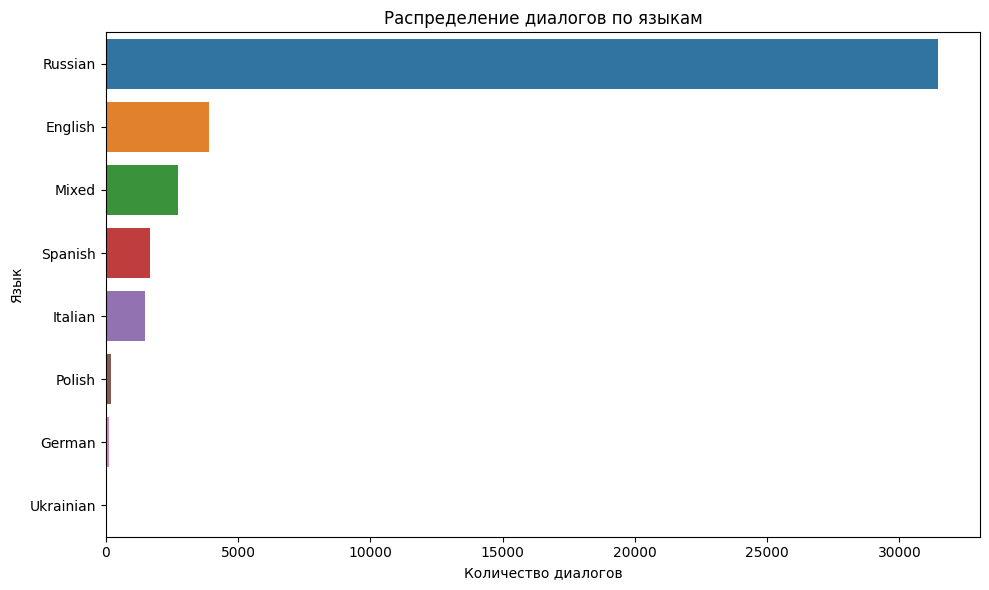

Количество диалогов на русском: 31475


In [9]:
language_counts = df['language'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts.values, y=language_counts.index)
plt.title('Распределение диалогов по языкам')
plt.xlabel('Количество диалогов')
plt.ylabel('Язык')
plt.tight_layout()
plt.show()


russian_df = df[df['language'] == 'Russian']

print(f"Количество диалогов на русском: {len(russian_df)}")

Темы примерно одинаковые

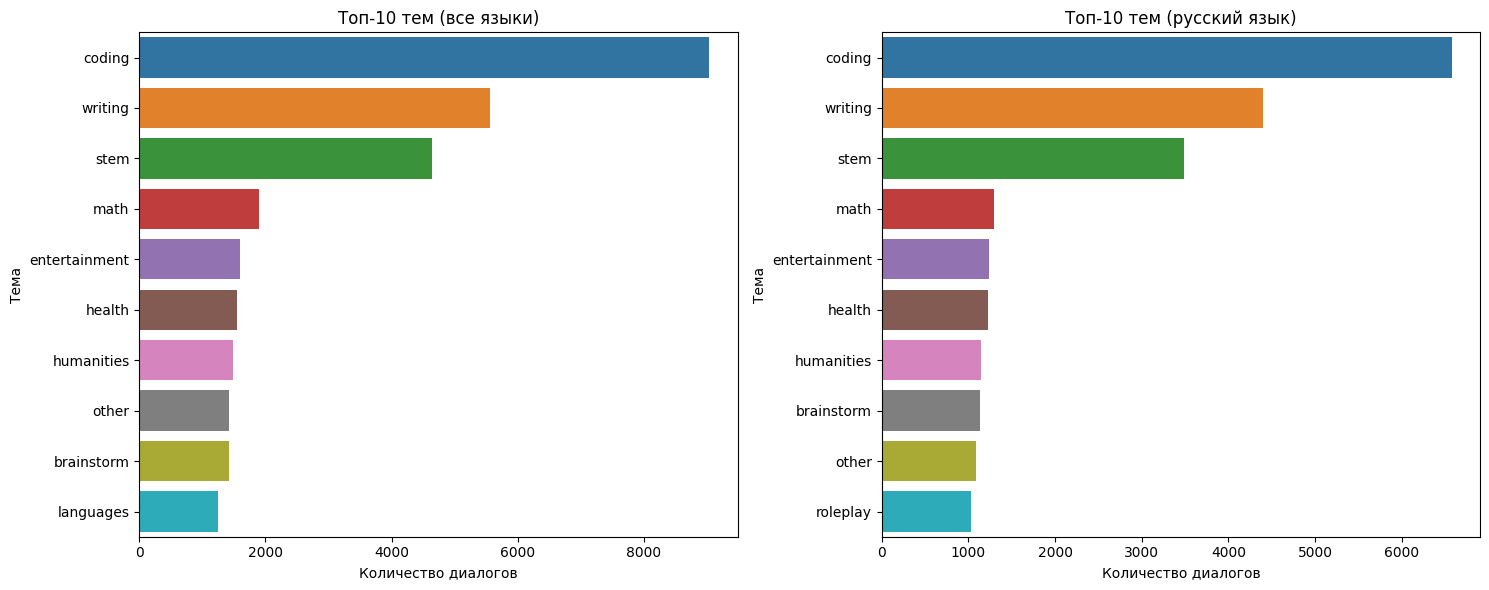

In [10]:
topic_counts = df['sonnet_topic'].value_counts().head(10)
russian_topic_counts = russian_df['sonnet_topic'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=topic_counts.values, y=topic_counts.index, ax=axes[0])
axes[0].set_title('Топ-10 тем (все языки)')
axes[0].set_xlabel('Количество диалогов')
axes[0].set_ylabel('Тема')

sns.barplot(x=russian_topic_counts.values, y=russian_topic_counts.index, ax=axes[1])
axes[1].set_title('Топ-10 тем (русский язык)')
axes[1].set_xlabel('Количество диалогов')
axes[1].set_ylabel('Тема')
plt.tight_layout()
plt.show()

Сложности аналогично

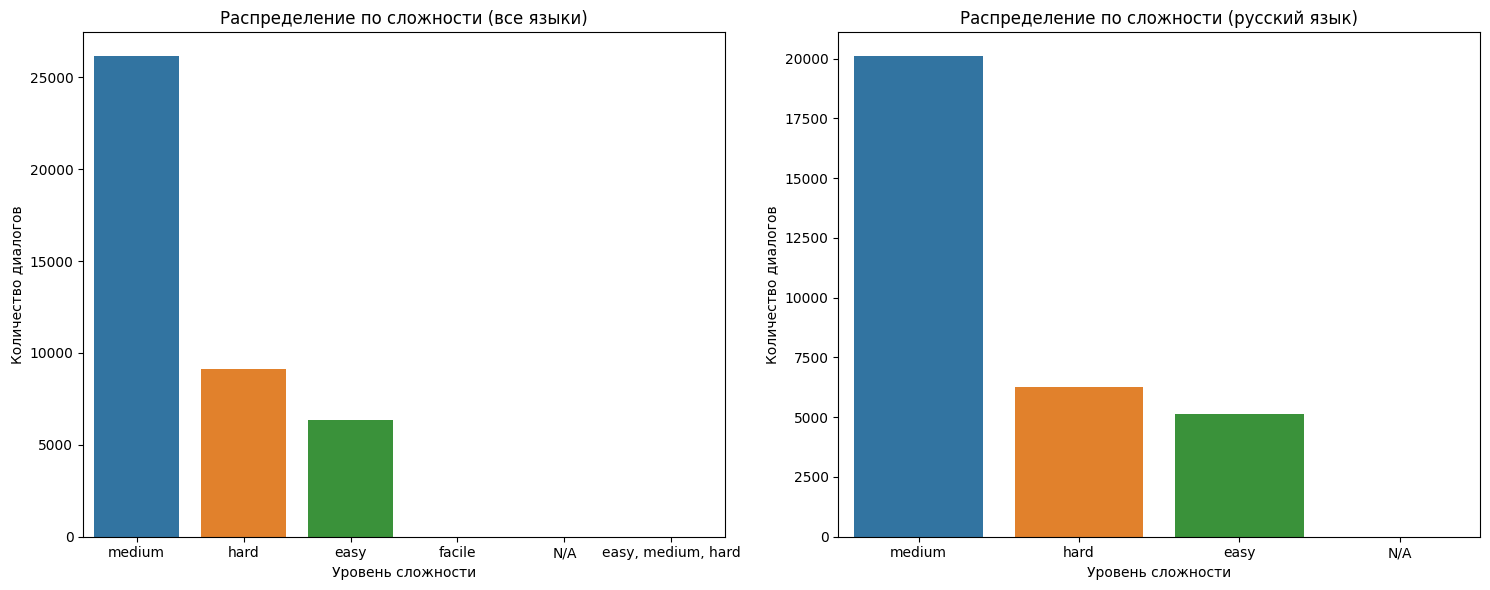

In [11]:
complexity_counts = df['sonnet_complexity'].value_counts()
russian_complexity_counts = russian_df['sonnet_complexity'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=complexity_counts.index, y=complexity_counts.values, ax=axes[0])
axes[0].set_title('Распределение по сложности (все языки)')
axes[0].set_xlabel('Уровень сложности')
axes[0].set_ylabel('Количество диалогов')

sns.barplot(x=russian_complexity_counts.index, y=russian_complexity_counts.values, ax=axes[1])
axes[1].set_title('Распределение по сложности (русский язык)')
axes[1].set_xlabel('Уровень сложности')
axes[1].set_ylabel('Количество диалогов')
plt.tight_layout()
plt.show()

Гистограмма для opus_score

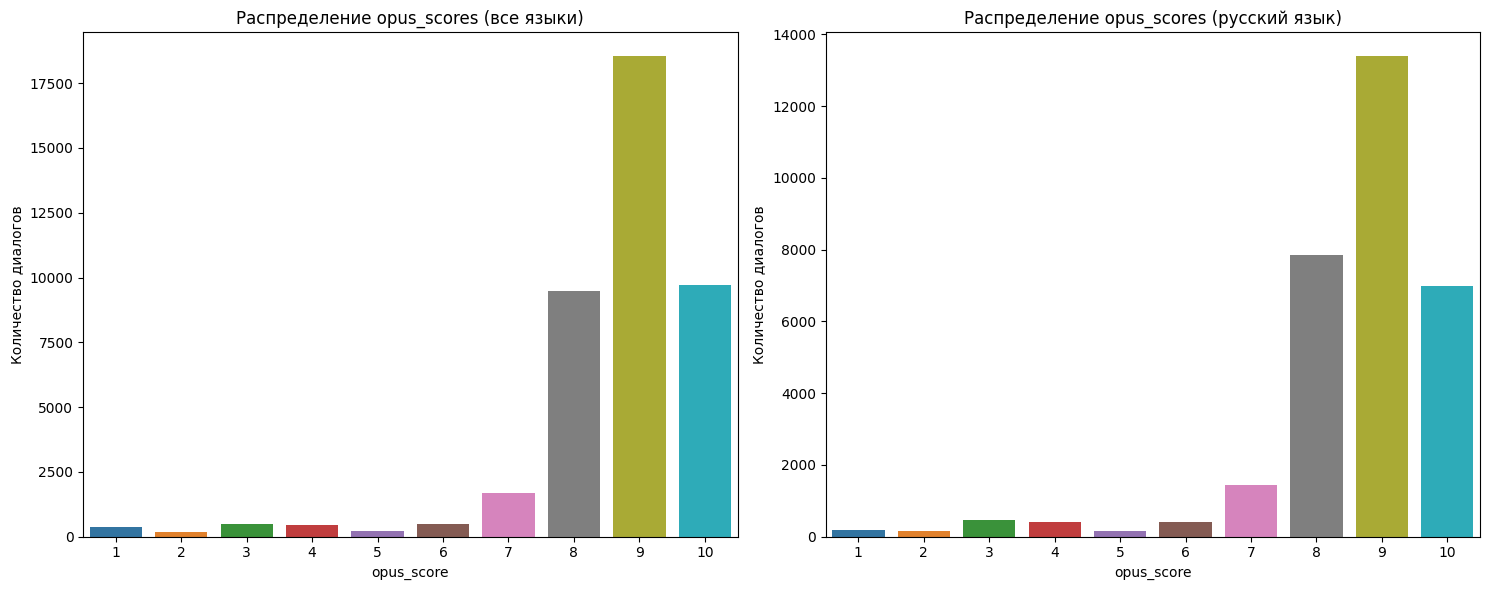

In [12]:
opus_scores = df['opus_score'].value_counts()
russian_opus_scores = russian_df['opus_score'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=opus_scores.index, y=opus_scores.values, ax=axes[0])
axes[0].set_title('Распределение opus_scores (все языки)')
axes[0].set_xlabel('opus_score')
axes[0].set_ylabel('Количество диалогов')

sns.barplot(x=russian_opus_scores.index, y=russian_opus_scores.values, ax=axes[1])
axes[1].set_title('Распределение opus_scores (русский язык)')
axes[1].set_xlabel('opus_score')
axes[1].set_ylabel('Количество диалогов')
plt.tight_layout()
plt.show()

Распределения длин

In [22]:
bot_lengths = []
dialog_lengths = []

for item in df['messages']:
    dialog_lengths.append(len(item))
    for msg in item:
        if msg["role"] == "bot":
            bot_lengths.append(len(msg["content"]))

bot_mean = np.median(bot_lengths)
bot_min = min(bot_lengths)
bot_max = max(bot_lengths)
dialog_mean = np.median(dialog_lengths)
dialog_min = min(dialog_lengths)
dialog_max = max(dialog_lengths)

print(f"Длина реплик модели (кол-во символов): Медиана={bot_mean:.2f}, Мин={bot_min}, Макс={bot_max}")
print(f"Диалоги (кол-во сообщений): Медиана={dialog_mean:.2f}, Мин={dialog_min}, Макс={dialog_max}")

Длина реплик модели (кол-во символов): Медиана=1160.00, Мин=1, Макс=70339
Диалоги (кол-во сообщений): Медиана=2.00, Мин=2, Макс=885


Исходя из проведенной аналитики попробуйте через различные эвристики отфильтровать датасет. При этом для простоты решения задачи важно будет оставить только одношаговые диалоги. В итоге будет достаточно 2k-3k качественных сэмплов.

In [28]:
def filter_example(example):
    if len(example['messages']) != 2:
        return False
    
    if example['language'] != 'Russian':
        return False
    
    if example['is_bad_by_regex']:
        return False
    
    if example['sonnet_complexity'] in ['easy', 'facile', 'N/A', 'easy, medium, hard']:
        return False
    
    if example['opus_score'] < 10:
        return False
    
    return True

Итого

In [60]:
filtered_data = dataset["train"].filter(filter_example)
filtered_data.shape

(2288, 11)

2к примеров! То, что нужно!

Как вы могли заметить вместо привычного `assistant` в списке сообщений `messages` встречается роль `bot`. Давайте использовать более классический вариант.

In [61]:
def rename_bot_in_messages(example):
    for msg in example['messages']:
        if msg["role"] == "bot":
            msg["role"] = "assistant"
    return example

filtered_data = filtered_data.map(rename_bot_in_messages)

Теперь разберемся с токенизатором.

In [62]:
tokenizer = LlamaTokenizerFast.from_pretrained(MODEL_NAME, legacy=False)
tokenizer

LlamaTokenizerFast(name_or_path='yandex/YandexGPT-5-Lite-8B-pretrain', vocab_size=129024, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("
", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	4: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	6: AddedToken("[CLS]", rstrip=False, ls

С 128000 по 129024 токен находятся зарезервированные спец. токены. Они предварительно добавлены в токенизатор и эмбеддинг слой модели для удобства, но не участвовали в претрейне. Например спец. токены пригодятся нам, чтобы грамотно обучить модель следовать чат-шаблону. Можно использовать токены с 128000 включительно, поменяв представление `[SPEC_TOKEN_{IDX}]` из токенизатора на наболее привычный `<|start_header_id|>` и т. п.

**Важно:** Мы будем делать LoRA-обучение, исходные эмбеддинги трогать не будем, поэтому в случае добавления спец. токенов они останутся необучаемыми, что будет не совсем корректно. Поэтому в данном случае мы все так же будем использовать условный `<|start_header_id|>`, но токенизироваться он будет не в один спец. токен, а в несколько простых.

Будем использовать chat-template от серии моделей `llama-3`.

In [63]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3",
    # system_message= есть возможность задать системное сообщение
)

Model does not have a padding token! Will use pad_token = <unk>.


У нашего токенизатора появился чат-шаблон! Посмотрим на него. 

In [64]:
tokenizer.chat_template

"{{ bos_token }}{% for message in messages %}{% if message['role'] == 'user' %}{{ '<|start_header_id|>user<|end_header_id|>\n\n' + message['content'] | trim + '<|eot_id|>' }}{% elif message['role'] == 'assistant' %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' + message['content'] | trim + '<|eot_id|>' }}{% else %}{{ '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n' + message['content'] | trim + '<|eot_id|>' }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' }}{% endif %}"

Еще раз обратим внимание, `<|start_header_id|>` и похожие токены участвуют в шаблоне, но они НЕ добавлены как спец. токены, поэтому токенизируются в несколько токенов, как обычный текст.

In [65]:
tokenizer("<|start_header_id|>assistant<|end_header_id|>\n\n")

{'input_ids': [1, 1078, 125853, 4991, 125865, 8264, 125865, 367, 73136, 108651, 125906, 125853, 617, 125865, 8264, 125865, 367, 73136, 3, 3], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Посмотрим на пример применения чат-шаблона. Обучать модель будем предсказывать только `assistant`-реплики модели.

In [66]:
chat_template_sample = tokenizer.apply_chat_template(filtered_data[1800]["messages"], tokenize=False)
chat_template_sample

'<s><|start_header_id|>user<|end_header_id|>\n\nНапиши код на C++ для решения следующей задачи\n\nЭта задача посвящена моделям Generative Flow Networks (GFlowNets), которые являются одним из методов генерации дискретных объектов.\nФормально задача генерации дискретных объектов формулируется так: у нас есть конечное множество объектов Х и неотрицательная reward функция R(x), определенная для всех х Є Х. Задача состоит в том, чтобы построить и обучить модель, которая генерирует объекты из Х из вероятностного распределения P(x) = R(x) для Z = ∑ R(x).\nTEX\nГенеративный процесс с помощью GFlowNet может быть рассмотрен как последовательность действий, при которой мы стартуем из некоторого пустого объекта и на каждом шаге добавляем некоторый компонент в него.\nОпределим процесс формально.\nРассмотрим ориентированный ациклический граф (DAG) G = (S, E), где S это множество состояний и ЕС SX S это множество возможных переходов от одного состояния к следующему.\nВ множестве состояний S есть ровн

Теперь загрузим модель

In [67]:
# Будем использовать квантизацию в 4бита, подробнее, что это значит
# мы узнаем на след. занятии
dtype = None
load_in_4bit = True

# Загрузка модели через знакомый метод .from_pretrained
model, unsloth_tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1. vLLM: 0.8.5.dev89+g3d3ab3689.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Unsloth: Will load yandex/YandexGPT-5-Lite-8B-pretrain as a legacy tokenizer.


yandex/YandexGPT-5-Lite-8B-pretrain does not have a padding token! Will use pad_token = <unk>.


Важно помнить, что это пока базовая модель, она просто продолжает текст!

In [68]:
prompt = "План изучения машинного обучения:"
device = torch.device("cuda:0")
tokenized_prompt = tokenizer(prompt, return_tensors="pt").to(device)
# Посмотрим на генерацию
outputs = model.generate(**tokenized_prompt,
                         do_sample=True,
                         temperature=0.3,
                         max_new_tokens=128,
                         # Используем KV-cache, а не пересчитываем векторы key/value
                         use_cache=True)
tokenizer.batch_decode(outputs)[0]

'<s> План изучения машинного обучения: 100 дней машинного обучения, чтобы стать экспертом в области машинного обучения\n\n#### План обучения на 100 дней ####\n\n#### День 1: Введение в машинное обучение ####\n\n**Что такое машинное обучение?**\n\nМашинное обучение — это подмножество искусственного интеллекта, которое позволяет компьютерным системам учиться на данных и улучшать свои результаты с течением времени без явного программирования.\n\n**Типы машинного обучения**\n\n**Обучение с учителем** : модели обучаются на помеченных данных, где известны как входные, так и выходные данные.\n\n**Обучение без учителя** : модели обучаются'

Теперь добавим обучаемые LoRA-адаптеры. Полноценный SFT в рамках Colab'a будет сделать сложно, поэтому обойдемся peft-методом, функционал есть прямо в `unsloth`!

In [69]:
model = FastLanguageModel.get_peft_model(
    model,
    # Знакомые гиперпараметры LoRA
    r=32,
    target_modules=[
        "q_proj",    # Attention
        "k_proj",    # Attention
        "v_proj",    # Attention
        "o_proj",    # Attention
        "gate_proj", # MLP
        "up_proj",   # MLP
        "down_proj", # MLP
    ],
    lora_alpha=32,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth", # Подробнее на след. занятии
    random_state=3407,
    use_rslora=False,  # Без rank stabilized LoRA
    loftq_config=None, # And LoftQ
)

Напишем функцию для применения чат-шаблона к каждому сэмплу. Учтите, что токенизировать текст на этом этапе не стоит, добавлять спец. токены и `generation_prompt` тоже. Важно грамотно указать аргументы `.apply_chat_template(...)`.

In [70]:
def formatting_prompts_func(examples):
    convos = examples["messages"]
    texts = []
    for convo in convos:
        formatted_text = tokenizer.apply_chat_template(
            convo,
            tokenize=False,
            add_special_tokens=False,
            add_generation_prompt=False
        )
        texts.append(formatted_text)
    return {
        # Отформатированные тексты сообщений для последующей токенизации
        "text" : texts
    }

filtered_data = filtered_data.map(formatting_prompts_func, batched=True)

Посмотрим на получившийся пример. В поле `text` должно быть что-то похожее:
```
<s><|start_header_id|>user<|end_header_id|>\n\nкрасивые места ульяновска<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nУльяновск — город ....<|eot_id|>
```

In [71]:
filtered_data[5]["text"]

'<s><|start_header_id|>user<|end_header_id|>\n\nчто такое col-sm-12<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n`col-sm-12` является классом в Bootstrap, популярном фреймворке для разработки адаптивных и мобильно-ориентированных веб-страниц. Bootstrap использует систему сеток для создания макетов страниц, которая включает в себя ряд контейнеров, строк и столбцов.\n\nВ контексте Bootstrap, `col-sm-12` обозначает класс, который применяется к элементу для указания, что он должен занимать все 12 колонок в сетке Bootstrap на экранах среднего размера (sm) и больше. Bootstrap по умолчанию использует 12-колоночную сетку, так что `col-sm-12` означает, что элемент будет занимать 100% доступной ширины в родительском контейнере на экранах размером с планшеты и больше.\n\nРазбивка на классы по размерам экранов в Bootstrap выглядит следующим образом:\n\n- `col-` для экранов меньше 576px\n- `col-sm-` для экранов шириной 576px и больше\n- `col-md-` для экранов шириной 768px и больше\n- `

Теперь зададим data-collator. Этот объект подготавливает тензоры перед форвародом. Обратите внмиание, мы будем использовать `DataCollatorForCompletionOnlyLM`. Он позволяет обучаться только ответах модели, то есть на токенах после `assistant<|end_header_id|>\n\n`. 

In [72]:
tokenizer.add_bos_token = False # при токенизации не добавляем bos, т.к. он есть в чат-шаблоне и уже находится в сэмплах.
# Предварительно токенизированная часть  assistant<|end_header_id|>\n\n
tokenized_assistant_response_template = [108651, 125906, 125853, 617, 125865, 8264, 125865, 367, 73136, 3, 3]
# Обучаться будем только на ответах модели, то есть токенах после assistant<|end_header_id|>\n\n
collator = DataCollatorForCompletionOnlyLM(
    # явно указываем начало assistant-реплики, до нее включительно будет стоять -100 для подсчет Cross-Entropy
    response_template=tokenized_assistant_response_template,
    tokenizer=tokenizer
)

Зададим трейнер.

In [73]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=filtered_data,
    # Передаем поле, в котором отформатированные сообщения
    # Токенизацию выполнит trainer
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    dataset_num_proc=2,
    data_collator=collator,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size=2,
        # На след. занятии поговорим об этом
        gradient_accumulation_steps=4,
        # Используем небольшой warmup
        warmup_steps=5,
        # Для знакомства модели с SFT форматом будет достаточно
        max_steps=100,
        learning_rate=2e-4,
        # На след. занятии поговорим об этом
        fp16=True,
        logging_steps=1,
        # На след. занятии поговорим об этом
        optim="adamw_8bit",
        # Регуляризация
        weight_decay=0.01,
        # Линейный шедулер
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none"
    ),
)

Посмотрим, как работает `DataCollatorForCompletionOnlyLM`. Обратите внимание, что в `labels` имеется некоторый префикс из `-100`. Так мы обучаем модель предсказывать токены реплики модели, игнорируя при подсчете лосса запрос юзера и системный промпт. При этом, в наших данных сейчас только одношаговые диалоги. В более продвинутом случае (многошаговые диалоги) процесс маскирования реплик модели был бы немного сложнее.

In [74]:
collator([trainer.train_dataset[7]["input_ids"]])

{'input_ids': tensor([[     1, 125906, 125853,   4991, 125865,   8264, 125865,    367,  73136,
            2478, 125906, 125853,    617, 125865,   8264, 125865,    367,  73136,
               3,      3, 125892,   2797,  21273,  44924,   1360,   3349,  24845,
          125827,    324,  70331,    450, 125837, 125837, 125837, 125864,    273,
           50551,    455,  78116,  79725,  13061, 125827,    273,  50551,    359,
            4142, 125827,    410,    273,  50551,    408,   1349,   5143, 125820,
           32024,   3342,    840, 125827,   1387,    324,  19620,  70331,    450,
          125876, 125876, 125876, 125876, 125864,    273,  50551,    455,   2588,
           78116,  45070,  79725,   2314,  13061,    545,  24845,    450, 125837,
          125837, 125837,    789,    410,    273,  50551,    359,  24845,    450,
          125876, 125876, 125876, 125876, 125864,    487,   1214,   1334,  23354,
            5143, 125827,   3444,  16175,  29535,  11827,  10255,    545,  28200,
   

Обучим модель. Если вы нигде значительно не ошиблись, то лосс будет в районе 0.7 – 1.4.

In [75]:
trainer.args.max_steps = 20
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,288 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.838000
2,1.360000
3,0.881700
4,0.729900
5,0.761500
6,0.886700
7,0.945100
8,0.687900
9,0.916400
10,0.659800


Настало время проверить модель на разных запросах. Сделать это можно так:

In [76]:
# Перевод модели в eval-model
FastLanguageModel.for_inference(model)

# Уже знакомый код генерации
messages = [
    {"role": "user", "content": "Расскажи коротко, что такое лог регрессия?"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

outputs = model.generate(
    input_ids=inputs,
    max_new_tokens=128,
    use_cache=True, # Использование KV-cache, а не пересчет
    do_sample=True,
    temperature=0.6
)
tokenizer.batch_decode(outputs)[0]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'<s><|start_header_id|>user<|end_header_id|>\n\nРасскажи коротко, что такое лог регрессия?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nЛогистическая регрессия — это статистическая модель, используемая для прогнозирования вероятности наличия определенного события или класса на основе различных входных признаков. Она является одним из самых популярных методов в машинном обучении для задач классификации, особенно когда зависимая переменная является бинарной (например, да/нет, 0/1).<|eot_id|>\n\nОсновные концепции:\n\n- **Зависимая переменная**: Обычно это бинарная переменная, которая принимает значения 0 или 1 (например, наличие заболевания или отсутствие).\n- **Независимые переменные (предикторы)**: Это входные переменные, которые используются для предсказания значения зависи'

Обернем в функцию запрос к модели

In [77]:
def generate_response(content, model):
    FastLanguageModel.for_inference(model)

    messages = [
        {"role": "user", "content": content},
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=128,
        use_cache=True,
        do_sample=True,
        temperature=0.6
    )

    return tokenizer.batch_decode(outputs)[0]

In [78]:
generate_response("Как правильно приготовить говядину?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nКак правильно приготовить говядину?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nГовядина — это отличный источник белка и питательных веществ, но ее приготовление может быть сложным, особенно для начинающих кулинаров. Следуя нескольким простым советам, вы сможете приготовить вкусную и сочную говядину.\n\n1. **Выбор мяса:**\n   - **Качество** — выбирайте свежее мясо с насыщенным красным цветом и приятным запахом.\n   - **Часть туши** — в зависимости от блюда, выбирайте разные части туши:\n     - **Риб-стейк** (ребро) — для жарки на гриле или сковороде.\n     - **Стейк из вырезки** — для жарки на гриле или сковороде.\n    '

In [79]:
generate_response("Как работает протокол HTTPS?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nКак работает протокол HTTPS?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nHTTPS (Hypertext Transfer Protocol Secure) - это протокол, который обеспечивает безопасную передачу данных между клиентом и сервером через интернет. Он использует шифрование для защиты передаваемой информации от несанкционированного доступа и перехвата.\n\nОсновной принцип работы HTTPS основан на использовании криптографических протоколов, таких как SSL (Secure Sockets Layer) и TLS (Transport Layer Security). Они обеспечивают шифрование данных на уровне протокола передачи, что делает невозможным их перехват и расшифровку сторонними лицами.\n\nПроцесс работы HTTPS можно разделить на несколько этапов:\n\n1. Установление соединения: Когда клиент (например, браузер) отправляет запрос на подключение к серверу,'

In [80]:
generate_response("Почему распался СССР?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nПочему распался СССР?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nРаспад СССР был результатом сложного взаимодействия экономических, политических, социальных и идеологических факторов, которые привели к нестабильности и кризису в Советском Союзе в 1980-х и начале 1990-х годов. Вот некоторые из основных причин:\n\n1. Экономический кризис: Экономика СССР столкнулась с серьезными проблемами, такими как снижение производительности, дефицит товаров, инфляция и неэффективное распределение ресурсов. Это привело к ухудшению жизни граждан и снижению доверия к советскому режиму.\n\n2. Политические реформы: В 1980-х годах Михаил Горбачев начал проводить политические реформы, известные как "пере'

In [81]:
generate_response("Сколько зарабатывают выпускники МФТИ?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nСколько зарабатывают выпускники МФТИ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nТочные цифры заработка выпускников Московского физико-технического института (МФТИ) могут существенно варьироваться в зависимости от специальности, выбранного направления, опыта работы, региона проживания и других факторов. Однако, можно привести некоторые общие сведения и тенденции.\n\n1. **Выпускники с инженерными и техническими специальностями**: В среднем, выпускники с инженерными и техническими специальностями могут рассчитывать на зарплату в диапазоне от 80 000 до 200 000 рублей в месяц, в зависимости от опыта работы и специализации.\n\n2. **Выпускники с научными специальностями**: Выпускники с научными и исследовательскими специально'

In [82]:
generate_response("Что такое байесовский фактор?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nЧто такое байесовский фактор?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nБайесовский фактор, также известный как отношение правдоподобия или отношение вероятностей, представляет собой меру того, насколько вероятно, что некоторые данные или наблюдения будут получены при условии двух конкурирующих гипотез. Он используется в байесовской статистике для сравнения двух моделей или гипотез с учетом новых данных.\n\nБайесовский фактор вычисляется как отношение вероятности получения данных при условии первой гипотезы (\\(H_1\\)) к вероятности получения данных при условии второй гипотезы (\\(H_2\\)). Формально, байесовский фактор (BF) между двумя гипотезами можно записать следующим образом:\n\n\\'

Очень приличный результат!

Если вы все сделали корректно, то модель точно должны выучить SFT-формат и в целом ответить на запрос, при чем достаточно развернуто.

vllmОбучите еще один вариант модели, достаточно отличающийся от начального. Например, вы можете использовать другие эвристики для фильтрации датасета или кардинально, но разумно изменить гиперпараметры обучения или LoRA-адаптеров.
Сравните две получившиеся модели на 5-10 содержательных запросах, оцените результаты и сделайте выводы.

Сделаем модель сильно проще, добавим Dropout

In [89]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

In [90]:
model, _ = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)
model = FastLanguageModel.get_peft_model(
    model,
    # Знакомые гиперпараметры LoRA
    r=8,
    target_modules=[
        "q_proj",    # Attention
        "k_proj",    # Attention
        "v_proj",    # Attention
        "o_proj",    # Attention
        "gate_proj", # MLP
        "up_proj",   # MLP
        "down_proj", # MLP
    ],
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    use_gradient_checkpointing="unsloth", # Подробнее на след. занятии
    random_state=3407,
    use_rslora=False,  # Без rank stabilized LoRA
    loftq_config=None, # And LoftQ
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1. vLLM: 0.8.5.dev89+g3d3ab3689.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Unsloth: Will load yandex/YandexGPT-5-Lite-8B-pretrain as a legacy tokenizer.


yandex/YandexGPT-5-Lite-8B-pretrain does not have a padding token! Will use pad_token = <unk>.


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.3.19 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Обучим

In [92]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=filtered_data,
    # Передаем поле, в котором отформатированные сообщения
    # Токенизацию выполнит trainer
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    dataset_num_proc=2,
    data_collator=collator,
    packing=False,
    args = TrainingArguments(
        per_device_train_batch_size=2,
        # На след. занятии поговорим об этом
        gradient_accumulation_steps=4,
        # Используем небольшой warmup
        warmup_steps=5,
        # Для знакомства модели с SFT форматом будет достаточно
        max_steps=100,
        learning_rate=2e-4,
        # На след. занятии поговорим об этом
        fp16=True,
        logging_steps=1,
        # На след. занятии поговорим об этом
        optim="adamw_8bit",
        # Регуляризация
        weight_decay=0.01,
        # Линейный шедулер
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none"
    ),
)
trainer.args.max_steps = 20
trainer_stats = trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/2288 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,288 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 20,971,520/8,000,000,000 (0.26% trained)


Step,Training Loss
1,0.838100
2,1.360000
3,0.881300
4,0.729800
5,0.761900
6,0.886800
7,0.945300
8,0.687800
9,0.915800
10,0.659800


Лосс, конечно, стал больше.

In [93]:
generate_response("Как правильно приготовить говядину?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nКак правильно приготовить говядину?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nПриготовление говядины требует внимания к деталям и правильного подхода, чтобы мясо было нежным, сочным и вкусным. Вот несколько советов, как правильно приготовить говядину:\n\n1. Выбор мяса:\n- Говядина должна быть свежей, с розовым цветом и ярким запахом.\n- Выбирайте куски с умеренным количеством жира, так как жир помогает удерживать влагу во время приготовления.\n\n2. Разморозка:\n- Никогда не размораживайте говядину в воде или микроволновке. Лучше всего размораживать мясо в холодильнике.\n\n3. Подготовка мяса:\n- Перед приготовлением убедитесь, что мясо полностью разморожено.\n- Если вы'

In [94]:
generate_response("Как работает протокол HTTPS?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nКак работает протокол HTTPS?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nHTTPS (HyperText Transfer Protocol Secure) - это протокол, который обеспечивает безопасную передачу данных между клиентом и сервером в интернете. Он основан на HTTP (HyperText Transfer Protocol), но добавляет шифрование и аутентификацию для защиты передаваемых данных.\n\nВот как работает HTTPS:\n\n1. **Установление соединения**: Клиент (например, веб-браузер) отправляет запрос на сервер, указывая, что он хочет использовать HTTPS.\n\n2. **Выбор криптографического алгоритма**: Сервер отправляет клиенту набор возможных криптографических алгоритмов, которые он поддерживает.\n\n3. **Шифрование**: Клиент выбирает один из предложенных алгоритмов и использует его'

In [95]:
generate_response("Почему распался СССР?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nПочему распался СССР?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nРаспад СССР был обусловлен несколькими факторами:\n\n1. Экономические проблемы: СССР столкнулся с серьезными экономическими трудностями, такими как дефицит товаров, инфляция, снижение производительности и уровня жизни населения.\n\n2. Политический кризис: В конце 1980-х годов в стране начались политические изменения, вызванные перестройкой, инициированной Михаилом Горбачевым. Однако эти изменения привели к усилению напряженности и конфликтам в обществе.\n\n3. Национальные движения: В республиках СССР начали появляться национальные движения, которые стремились к независимости и самоопределению своих народов. Это привело к усилению национальных конфликтов и'

In [96]:
generate_response("Сколько зарабатывают выпускники МФТИ?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nСколько зарабатывают выпускники МФТИ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nЗарплата выпускников Московского физико-технического института (МФТИ) может значительно варьироваться в зависимости от выбранной специальности, опыта работы, региона проживания и сферы деятельности. Однако, МФТИ считается одним из самых престижных технических вузов России и его выпускники часто высоко ценятся на рынке труда.\n\nВот некоторые общие данные о зарплатах выпускников МФТИ:\n\n1. **Программисты и разработчики:** Выпускники МФТИ, специализирующиеся в области информационных технологий, часто имеют высокие зарплаты, особенно если они работают в крупных технологических компаниях или стартапах. По данным различных источников, начинающие разработчики в Москве могут получать от 80 000 до'

In [97]:
generate_response("Что такое байесовский фактор?", model)

'<s><|start_header_id|>user<|end_header_id|>\n\nЧто такое байесовский фактор?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nБайесовский фактор (или байесовское отношение вероятностей) - это отношение между двумя вероятностями, которые вычисляются с помощью теоремы Байеса. Он используется для сравнения двух гипотез или моделей на основе данных. Байесовский фактор показывает, насколько вероятно, что одна модель лучше другой, учитывая наблюдаемые данные.\n\nБайесовский фактор вычисляется следующим образом:\n\nBF = P(D | H1) / P(D | H0)\n\nгде:\n- D - наблюдаемые данные,\n- H1 и H0 - две гипотезы или модели,\n- P('

Получилось тоже хорошо! Дотюнить готовую модель под нужный формат инструкций не так сложно